In [175]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from keras import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.wrappers.scikit_learn import KerasRegressor
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp


In [176]:
df

,country,commodity,year,loss_percentage,activity,food_supply_stage,cause_of_loss
0,Myanmar,"Groundnuts, excluding shelled",2009,5.22,NaN,Whole supply chain,NaN
1,Myanmar,"Groundnuts, excluding shelled",2008,5.43,NaN,Whole supply chain,NaN
2,Myanmar,"Groundnuts, excluding shelled",2007,5.61,NaN,Whole supply chain,NaN
3,Myanmar,"Groundnuts, excluding shelled",2006,5.40,NaN,Whole supply chain,NaN
4,Myanmar,"Groundnuts, excluding shelled",2005,5.00,NaN,Whole supply chain,NaN
...,...,...,...,...,...,...,...
27768,Zambia,Millet,2000,1.27,Storage,Farm,NaN
27769,Zambia,Millet,2000,2.50,Winnowing,Farm,NaN
27770,Zambia,Millet,2000,1.00,Transportation,Transport,NaN
27771,Zambia,Millet,2000,2.38,Storage,Storage,NaN


In [177]:
df = pd.read_csv("Data/Data.csv")
df = df[["country", "commodity", "year", "loss_percentage", "activity", "food_supply_stage", "cause_of_loss"]]

def focus_on(country, commodity):
    new_df = df[df.country == country]
    new_df = new_df[new_df.commodity == commodity]
    return new_df

# data = focus_on("Kenya", "Maize (corn)")
data = focus_on("Benin", "Maize (corn)")
data = data.reset_index()
data.sort_values(by=(["index"]), ascending=False, inplace=True)
data

,index,country,commodity,year,loss_percentage,activity,food_supply_stage,cause_of_loss
151,3072,Benin,Maize (corn),2000,6.42,"Drying, Harvesting",Harvest,NaN
150,3071,Benin,Maize (corn),2000,2.36,Transportation,Farm,NaN
149,3070,Benin,Maize (corn),2000,4.00,Drying,Farm,NaN
148,3069,Benin,Maize (corn),2000,3.05,Storage,Farm,NaN
147,3068,Benin,Maize (corn),2000,1.65,Transportation,Transport,NaN
...,...,...,...,...,...,...,...,...
4,2452,Benin,Maize (corn),2020,2.36,Transportation,Farm,NaN
3,2451,Benin,Maize (corn),2020,4.00,Drying,Farm,NaN
2,2450,Benin,Maize (corn),2020,6.42,"Drying, Harvesting",Harvest,NaN
1,2449,Benin,Maize (corn),2020,3.04,Storage,Farm,NaN


In [178]:
validate = data[["activity","food_supply_stage","loss_percentage"]].tail(3)
data.drop(data.tail(3).index,inplace=True)

In [179]:
for i in data.select_dtypes('object').columns:
    le = LabelEncoder().fit(data[i])
    data[i] = le.transform(data[i])
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_data = X_scaler.fit_transform(data[["activity","food_supply_stage","loss_percentage"]])
Y_data = Y_scaler.fit_transform(data[['loss_percentage']])

In [180]:
X_data

array([[0.2       , 0.25      , 0.19859813],
       [0.8       , 0.        , 0.04049844],
       [0.        , 0.        , 0.10436137],
       [0.6       , 0.        , 0.0673676 ],
       [0.8       , 0.75      , 0.01285047],
       [0.4       , 0.        , 0.        ],
       [0.6       , 0.5       , 0.05179128],
       [1.        , 1.        , 0.64174455],
       [0.8       , 0.75      , 0.01285047],
       [0.6       , 0.5       , 0.05179128],
       [0.        , 0.        , 0.10436137],
       [0.2       , 0.25      , 0.19859813],
       [0.6       , 0.        , 0.0673676 ],
       [0.8       , 0.        , 0.04049844],
       [0.4       , 0.        , 0.        ],
       [1.        , 0.5       , 0.5911215 ],
       [0.6       , 0.5       , 0.05179128],
       [0.6       , 0.        , 0.0673676 ],
       [0.8       , 0.        , 0.04049844],
       [0.2       , 0.25      , 0.19859813],
       [0.        , 0.        , 0.10436137],
       [0.8       , 0.75      , 0.01285047],
       [0.

In [181]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
     X = []
     y = []
     start = start + window
     if end is None:
         end = len(dataset) - horizon
     for i in range(start, end):
         indices = range(i-window, i)
         X.append(dataset[indices])
         indicey = range(i+1, i+1+horizon)
         y.append(target[indicey])
     return np.array(X), np.array(y)

In [182]:
hist_window = 8
horizon = 3
TRAIN_SPLIT = 120
x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, hist_window, horizon)

In [183]:
print ('Multiple window of past history\n')
print(x_train[0])
print ('\n Target horizon\n')
print (y_train[0])

Multiple window of past history

[[0.2        0.25       0.19859813]
 [0.8        0.         0.04049844]
 [0.         0.         0.10436137]
 [0.6        0.         0.0673676 ]
 [0.8        0.75       0.01285047]
 [0.4        0.         0.        ]
 [0.6        0.5        0.05179128]
 [1.         1.         0.64174455]]

 Target horizon

[[0.05179128]
 [0.10436137]
 [0.19859813]]


In [184]:
batch_size = 256
buffer_size = 150
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat()

In [185]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True),
                                input_shape=x_train.shape[-2:]),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dropout(0.25),
     tf.keras.layers.Dense(units=horizon),
    ])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_29 (Bidirecti  (None, 8, 400)           326400    
 onal)                                                           
                                                                 
 dense_43 (Dense)            (None, 8, 20)             8020      
                                                                 
 bidirectional_30 (Bidirecti  (None, 300)              205200    
 onal)                                                           
                                                                 
 dense_44 (Dense)            (None, 20)                6020      
                                                                 
 dense_45 (Dense)            (None, 20)                420       
                                                                 
 dropout_10 (Dropout)        (None, 20)              

In [186]:
model_path = 'Bidirectional_LSTM_Multivariate.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]
history = lstm_model.fit(train_data,epochs=50,steps_per_epoch=100,validation_data=val_data,validation_steps=50,verbose=1,callbacks=callbacks)

Epoch 1/50
100/100 [==============================] - 14s 81ms/step - loss: 0.0216 - val_loss: 0.0084
Epoch 2/50
100/100 [==============================] - 7s 65ms/step - loss: 0.0189 - val_loss: 0.0108
Epoch 3/50
100/100 [==============================] - 7s 67ms/step - loss: 0.0157 - val_loss: 0.0272
Epoch 4/50
100/100 [==============================] - 7s 66ms/step - loss: 0.0092 - val_loss: 0.0168
Epoch 5/50
100/100 [==============================] - 7s 65ms/step - loss: 0.0057 - val_loss: 0.0116
Epoch 6/50
100/100 [==============================] - 6s 64ms/step - loss: 0.0037 - val_loss: 0.0119
Epoch 7/50
100/100 [==============================] - 6s 56ms/step - loss: 0.0026 - val_loss: 0.0175
Epoch 8/50
100/100 [==============================] - 6s 64ms/step - loss: 0.0022 - val_loss: 0.0129
Epoch 9/50
100/100 [==============================] - 6s 61ms/step - loss: 0.0021 - val_loss: 0.0154
Epoch 10/50
100/100 [==============================] - 6s 62ms/step - loss: 0.0018 - val_l

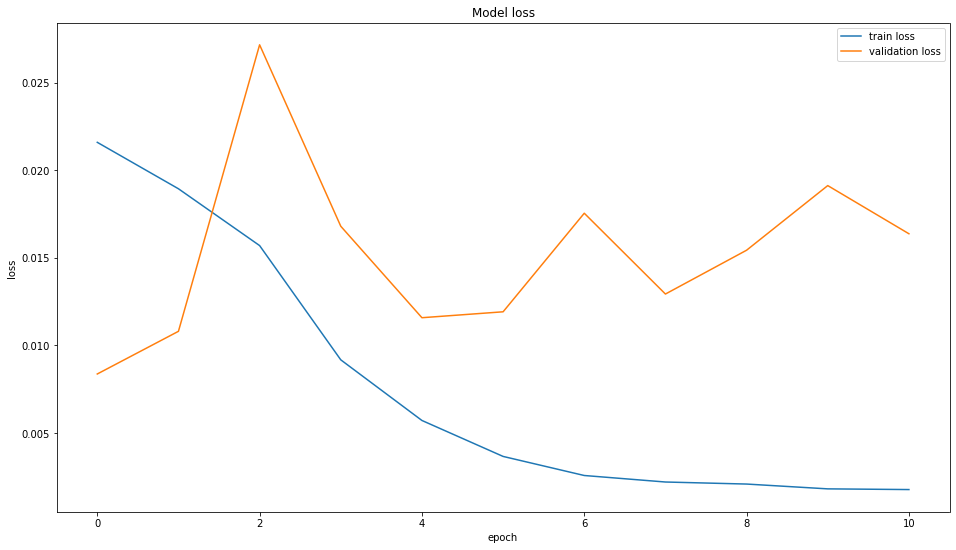

In [187]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [188]:
data_val = X_scaler.fit_transform(data[["activity","food_supply_stage","loss_percentage"]].tail(8))
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])
pred = lstm_model.predict(val_rescaled)
pred_Inverse = Y_scaler.inverse_transform(pred)
pred_Inverse

1/1 [==============================] - 2s 2s/step


array([[3.2527223, 4.6944757, 3.4822588]], dtype=float32)

In [189]:

data_val

array([[0.25      , 0.33333333, 1.        ],
       [0.        , 0.        , 0.5254902 ],
       [1.        , 1.        , 0.06470588],
       [1.        , 0.        , 0.20392157],
       [0.5       , 0.        , 0.        ],
       [1.        , 1.        , 0.06470588],
       [1.        , 0.        , 0.20392157],
       [0.        , 0.        , 0.5254902 ]])

In [190]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [191]:
timeseries_evaluation_metrics_func(validate["loss_percentage"],pred_Inverse[0])

Evaluation metric results:-
MSE is : 4.487197548295186
MAE is : 1.8846707280476889
RMSE is : 2.1183006274594707
MAPE is : 45.05469255237052
R2 is : -0.5659448430229737



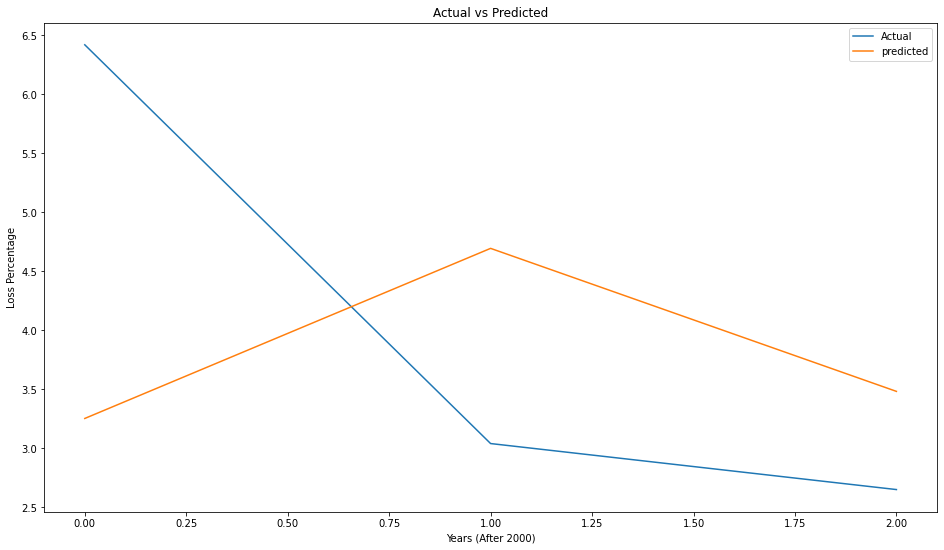

In [200]:
plt.figure(figsize=(16,9))
plt.plot( list(validate['loss_percentage']))
plt.plot( list(pred_Inverse[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Loss Percentage")
plt.xlabel('Years (After 2000)')
plt.legend(('Actual','predicted'))
plt.show()

In [193]:
data_val = X_scaler.fit_transform(data[["activity","food_supply_stage","loss_percentage"]].tail(8))
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

In [194]:
validate["loss_percentage"]

2    6.42
1    3.04
0    2.65
Name: loss_percentage, dtype: float64

In [195]:
pred_Inverse[0]

array([3.2527223, 4.6944757, 3.4822588], dtype=float32)

TUNING

In [196]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam','sgd']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [197]:
def train_test_model(hparams):
    lstm_model_opt = tf.keras.models.Sequential([
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True),
                                    input_shape=x_train.shape[-2:]),
         tf.keras.layers.Dense(20, activation='tanh'),
         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
         tf.keras.layers.Dense(20, activation='tanh'),
         tf.keras.layers.Dropout(0.25),
         tf.keras.layers.Dense(units=horizon),
        ])
    lstm_model_opt.compile(optimizer=hparams[HP_OPTIMIZER], loss='mse')
    lstm_model_opt.summary()
    model_path = 'Bidirectional_LSTM_Multivariate_opt.h5'
    early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='min')
    checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
    callbacks=[early_stopings,checkpoint]
    history = lstm_model.fit(train_data,epochs=50,steps_per_epoch=100,validation_data=val_data,validation_steps=50,verbose=1,callbacks=callbacks)
    (validate["loss_percentage"], pred_Inverse[0])
    return history

In [198]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    history = train_test_model(hparams)
    accuracy=model.evaluate(x_test, y_test)
    tf.summary.scalar(METRIC_ACCURACY, step=1)

In [199]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run('logs/hparam_tuning/' + run_name, hparams)
      session_num += 1

--- Starting trial: run-0
{'num_units': 16, 'dropout': 0.1, 'optimizer': 'adam'}
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_31 (Bidirecti  (None, 8, 400)           326400    
 onal)                                                           
                                                                 
 dense_47 (Dense)            (None, 8, 20)             8020      
                                                                 
 bidirectional_32 (Bidirecti  (None, 300)              205200    
 onal)                                                           
                                                                 
 dense_48 (Dense)            (None, 20)                6020      
                                                                 
 dropout_11 (Dropout)        (None, 20)                0         
                                      

NameError: name 'model' is not defined

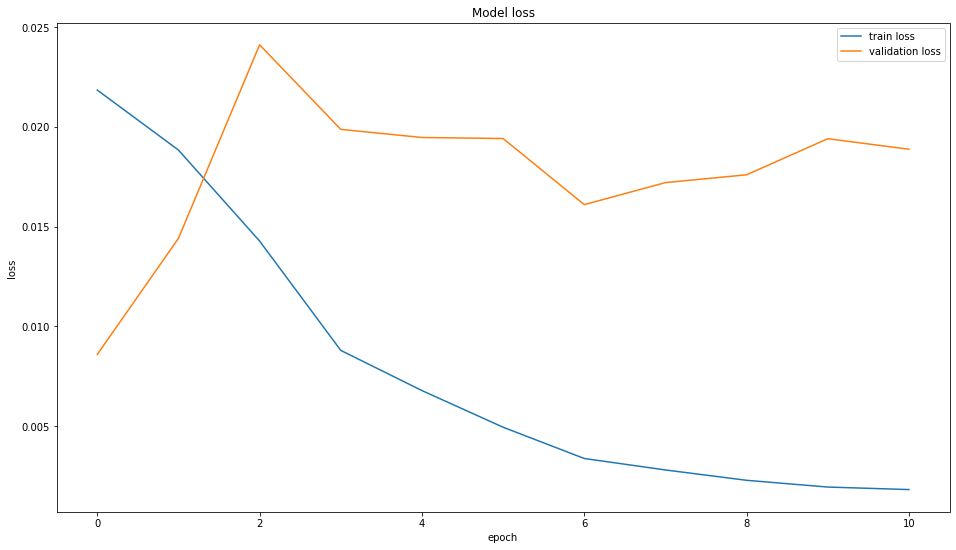

In [150]:
plt.figure(figsize=(16, 9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()


In [ ]:
data_val = X_scaler.fit_transform(data[["activity", "food_supply_stage", "loss_percentage"]].tail(8))
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])
pred = lstm_model.predict(val_rescaled)
pred_Inverse = Y_scaler.inverse_transform(pred)
pred_Inverse

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}', end='\n\n')


timeseries_evaluation_metrics_func(validate["loss_percentage"], pred_Inverse[0])
plt.figure(figsize=(16, 9))
plt.plot(list(validate['loss_percentage']))
plt.plot(list(pred_Inverse[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual', 'predicted'))
plt.show()